In [38]:
#put all the imports here
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [39]:
file_path = '/content/Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(file_path)
df.drop(columns=['Person ID'], inplace=True)
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


# Data Preprocessing



In [40]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['Gender', 'Occupation', 'BMI Category', 'Blood Pressure',
       'Sleep Disorder'],
      dtype='object')

In [41]:
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

def categorize_bp(row):
    systolic = row['Systolic_BP']
    diastolic = row['Diastolic_BP']
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif systolic >= 130 or diastolic >= 80:
        return 'Hypertension'
    return 'Unknown'

df['BP_Category'] = df.apply(categorize_bp, axis=1)
df.drop(columns=['Blood Pressure'], inplace=True)

In [42]:
df_original = df.copy()
label_encoder = LabelEncoder()

columns_to_encode = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder', 'BP_Category']

unique_mappings = {}

for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])
    unique_mappings[column] = pd.DataFrame({
        'Original': label_encoder.classes_,
        'Encoded': range(len(label_encoder.classes_))
    })

for column, mapping in unique_mappings.items():
    print(f"\nUnique values for '{column}':")
    print(mapping)

print("\nDataFrame after encoding:")
df.head()


Unique values for 'Gender':
  Original  Encoded
0   Female        0
1     Male        1

Unique values for 'Occupation':
                Original  Encoded
0             Accountant        0
1                 Doctor        1
2               Engineer        2
3                 Lawyer        3
4                Manager        4
5                  Nurse        5
6   Sales Representative        6
7            Salesperson        7
8              Scientist        8
9      Software Engineer        9
10               Teacher       10

Unique values for 'BMI Category':
        Original  Encoded
0         Normal        0
1  Normal Weight        1
2          Obese        2
3     Overweight        3

Unique values for 'Sleep Disorder':
      Original  Encoded
0     Insomnia        0
1  Sleep Apnea        1
2          NaN        2

Unique values for 'BP_Category':
       Original  Encoded
0      Elevated        0
1  Hypertension        1
2        Normal        2

DataFrame after encoding:


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic_BP,Diastolic_BP,BP_Category
0,1,27,9,6.1,6,42,6,3,77,4200,2,126,83,1
1,1,28,1,6.2,6,60,8,0,75,10000,2,125,80,1
2,1,28,1,6.2,6,60,8,0,75,10000,2,125,80,1
3,1,28,6,5.9,4,30,8,2,85,3000,1,140,90,1
4,1,28,6,5.9,4,30,8,2,85,3000,1,140,90,1


# Exploratory Data Analysis



In [43]:
print(df.dtypes)

# Convert all columns to integers (if possible)
for col in df.columns:
    try:
        df[col] = df[col].astype(int)
    except ValueError:
        print(f"Column '{col}' could not be converted to integer.  Check for non-numeric data.")
    except TypeError:
        print(f"Column '{col}' has an unsupported type for conversion.")

print("\nDataFrame after type conversion:")
df.dtypes

Gender                       int64
Age                          int64
Occupation                   int64
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                 int64
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder               int64
Systolic_BP                  int64
Diastolic_BP                 int64
BP_Category                  int64
dtype: object

DataFrame after type conversion:


,0
Gender,int64
Age,int64
Occupation,int64
Sleep Duration,int64
Quality of Sleep,int64
Physical Activity Level,int64
Stress Level,int64
BMI Category,int64
Heart Rate,int64
Daily Steps,int64


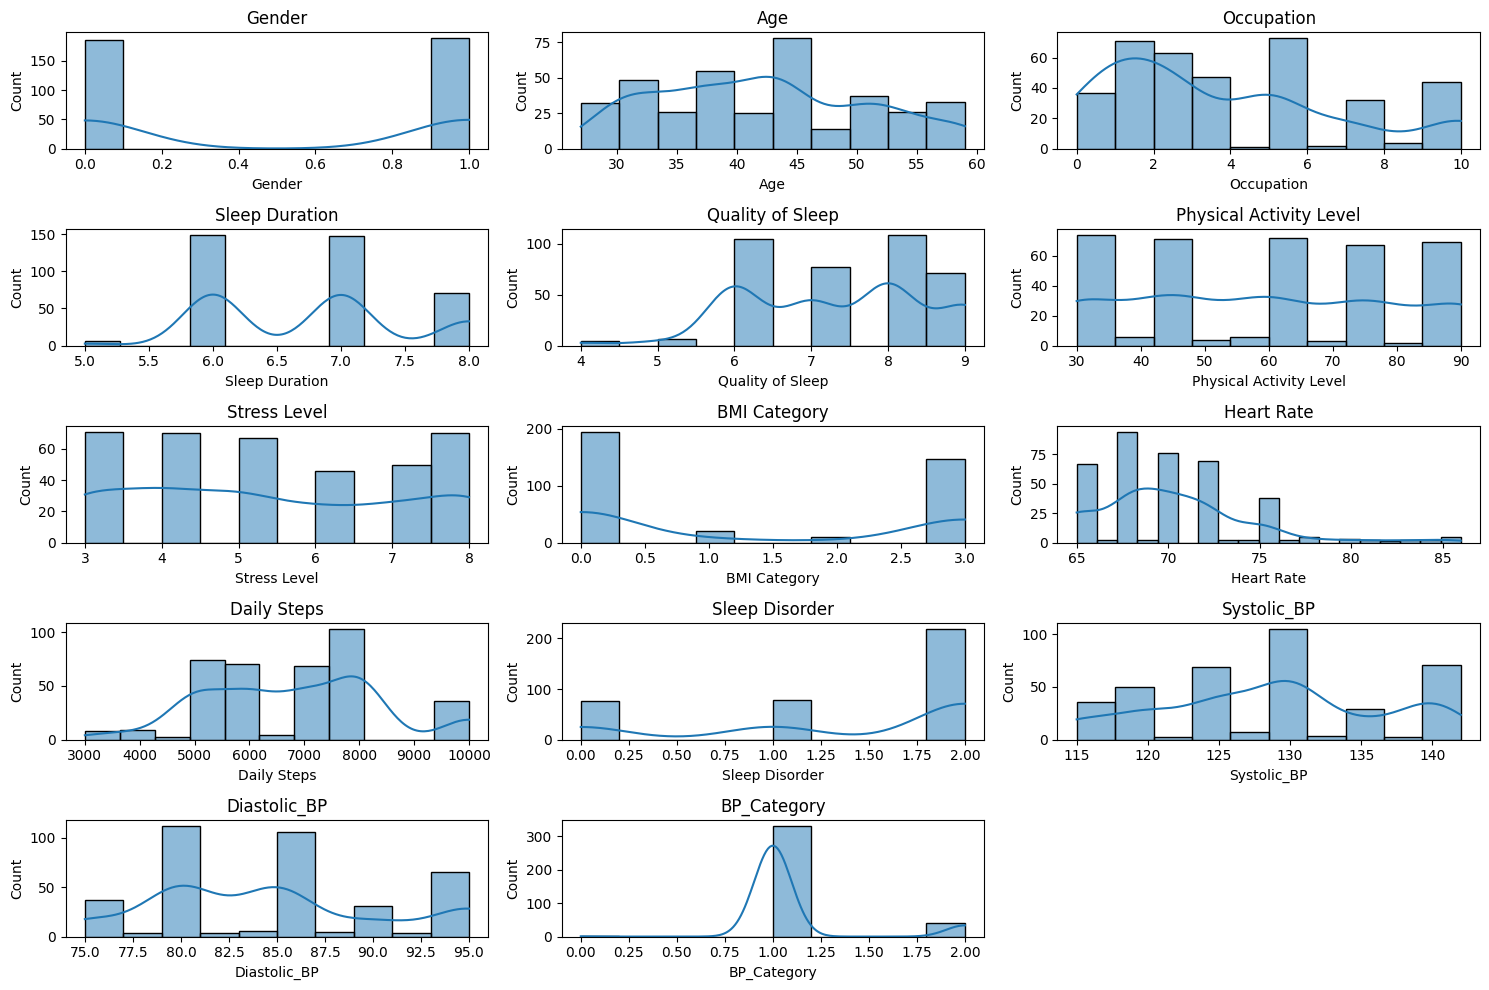

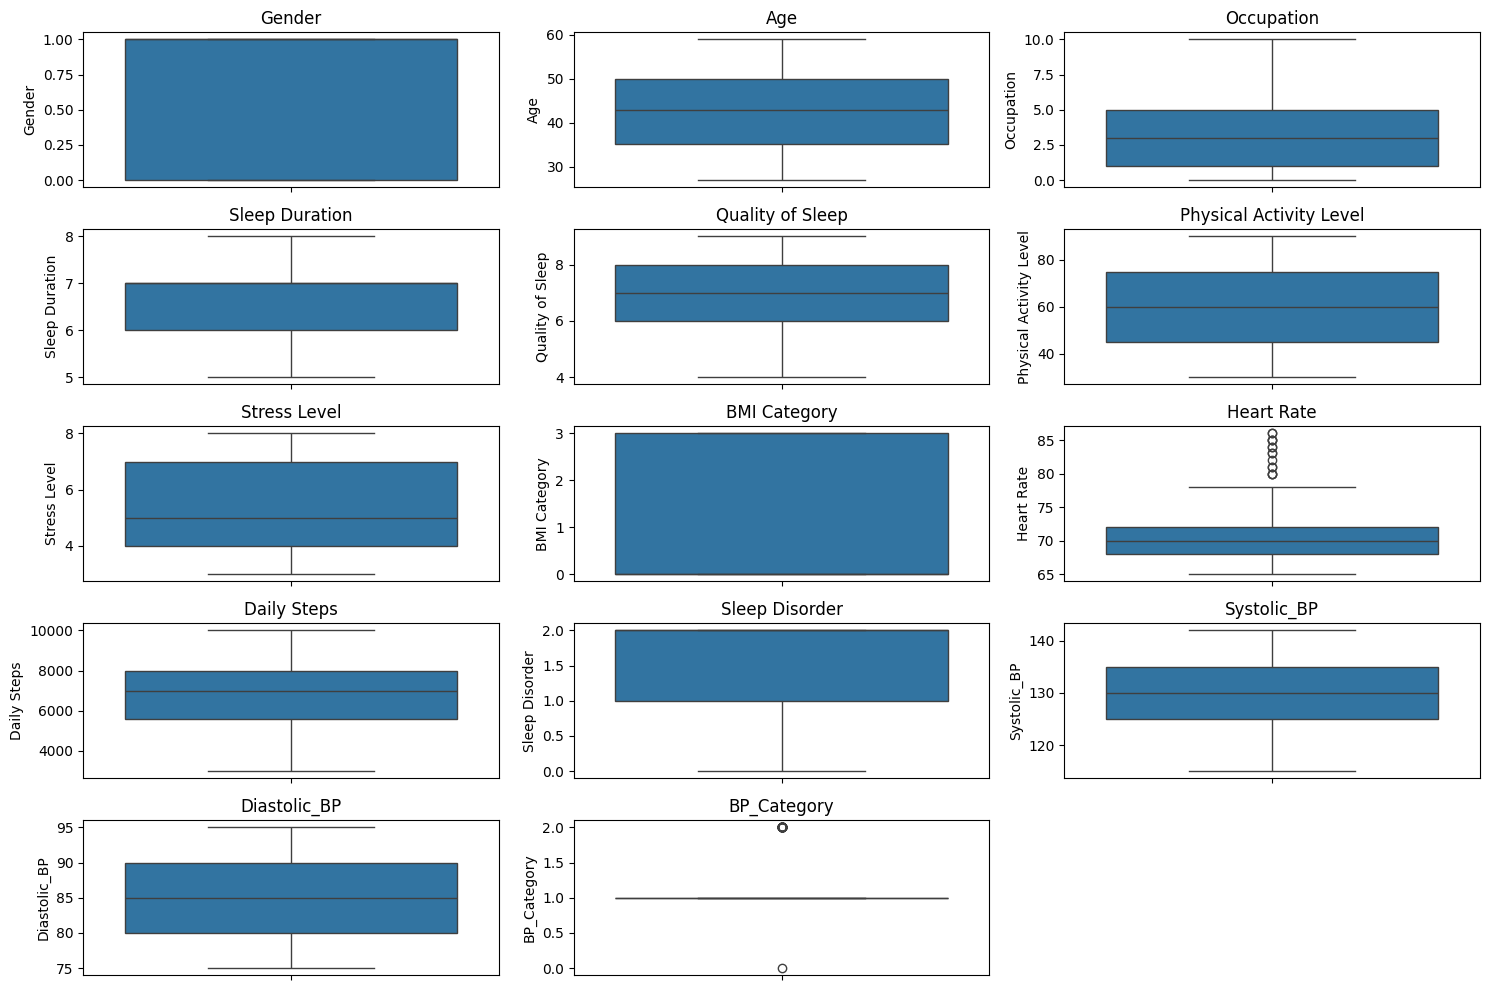

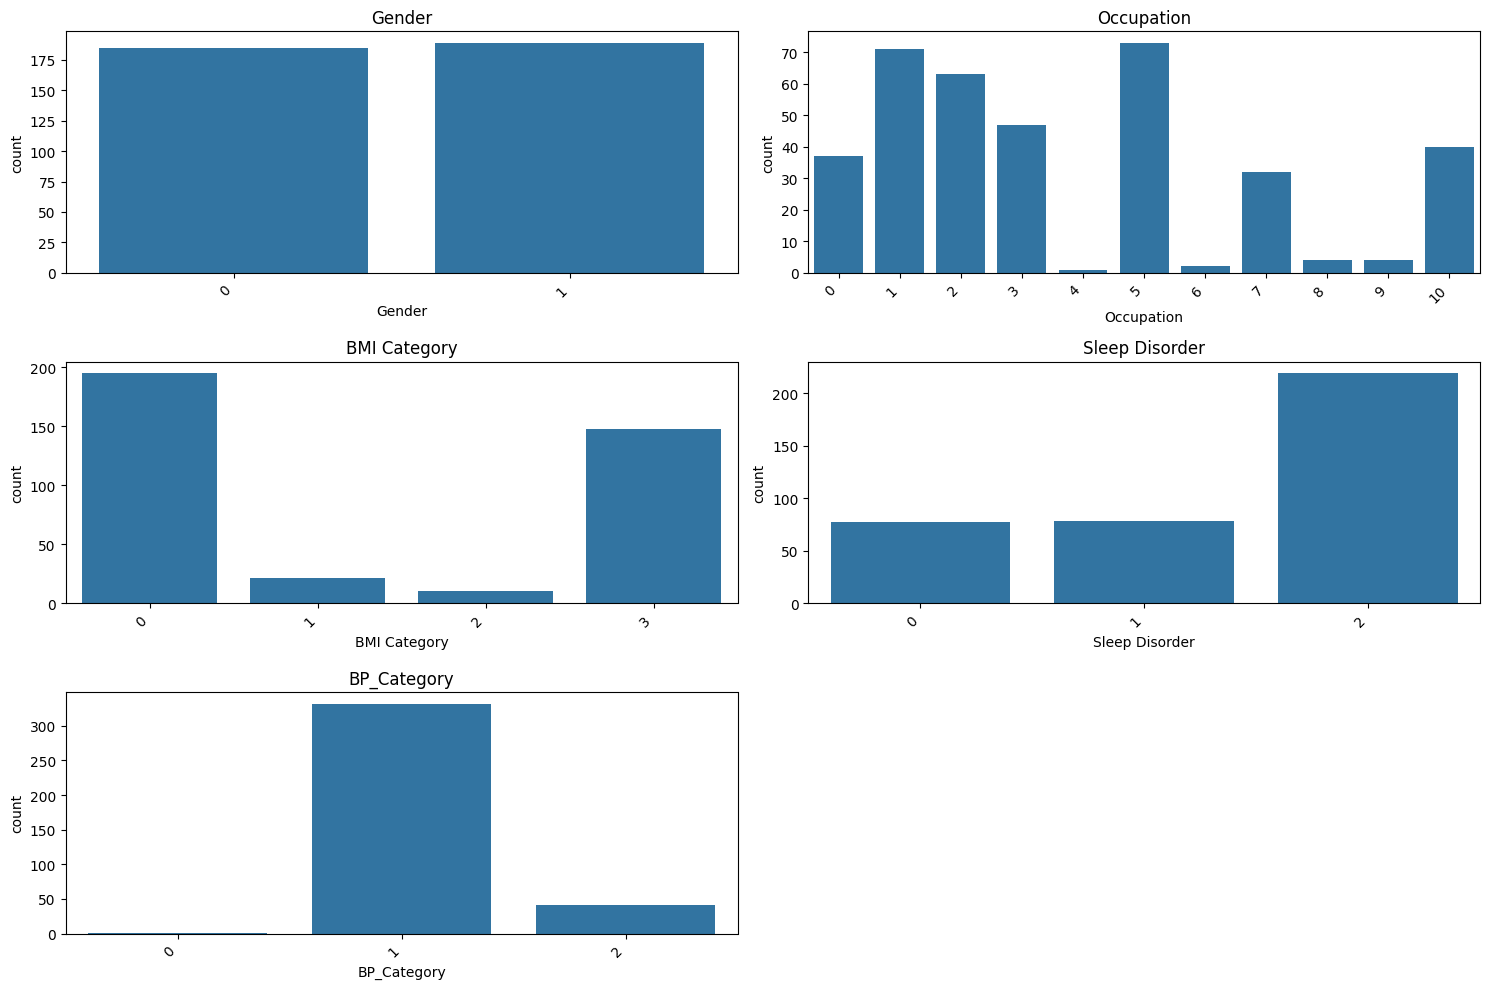

In [44]:
# Numerical features
numerical_cols = df.select_dtypes(include=np.number).columns

# Calculate the number of rows and columns for subplots
num_cols = len(numerical_cols)
num_rows = int(np.ceil(num_cols / 3))

# Plotting histograms for numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.tight_layout()
plt.show()


# Plotting box plots for numerical features to check for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()


categorical_cols_encoded = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder', 'BP_Category']


# Plotting count plots for categorical features
# Calculate the number of rows and columns for subplots (categorical)
num_cols_cat = len(categorical_cols_encoded)
num_rows_cat = int(np.ceil(num_cols_cat / 2))

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols_encoded):
    plt.subplot(num_rows_cat, 2, i + 1)
    sns.countplot(x=df[col])
    plt.title(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()

Scaling


In [45]:
# Numerical features
numerical_cols = df.select_dtypes(include=np.number).columns

scaler = MinMaxScaler()

# Fit and transform the numerical features
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nDataFrame after scaling:")
df.head()


DataFrame after scaling:


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic_BP,Diastolic_BP,BP_Category
0,1.0,0.00000,0.9,0.333333,0.4,0.2,0.6,1.000000,0.571429,0.171429,1.0,0.407407,0.40,0.5
1,1.0,0.03125,0.1,0.333333,0.4,0.5,1.0,0.000000,0.476190,1.000000,1.0,0.370370,0.25,0.5
2,1.0,0.03125,0.1,0.333333,0.4,0.5,1.0,0.000000,0.476190,1.000000,1.0,0.370370,0.25,0.5
3,1.0,0.03125,0.6,0.000000,0.0,0.0,1.0,0.666667,0.952381,0.000000,0.5,0.925926,0.75,0.5
4,1.0,0.03125,0.6,0.000000,0.0,0.0,1.0,0.666667,0.952381,0.000000,0.5,0.925926,0.75,0.5


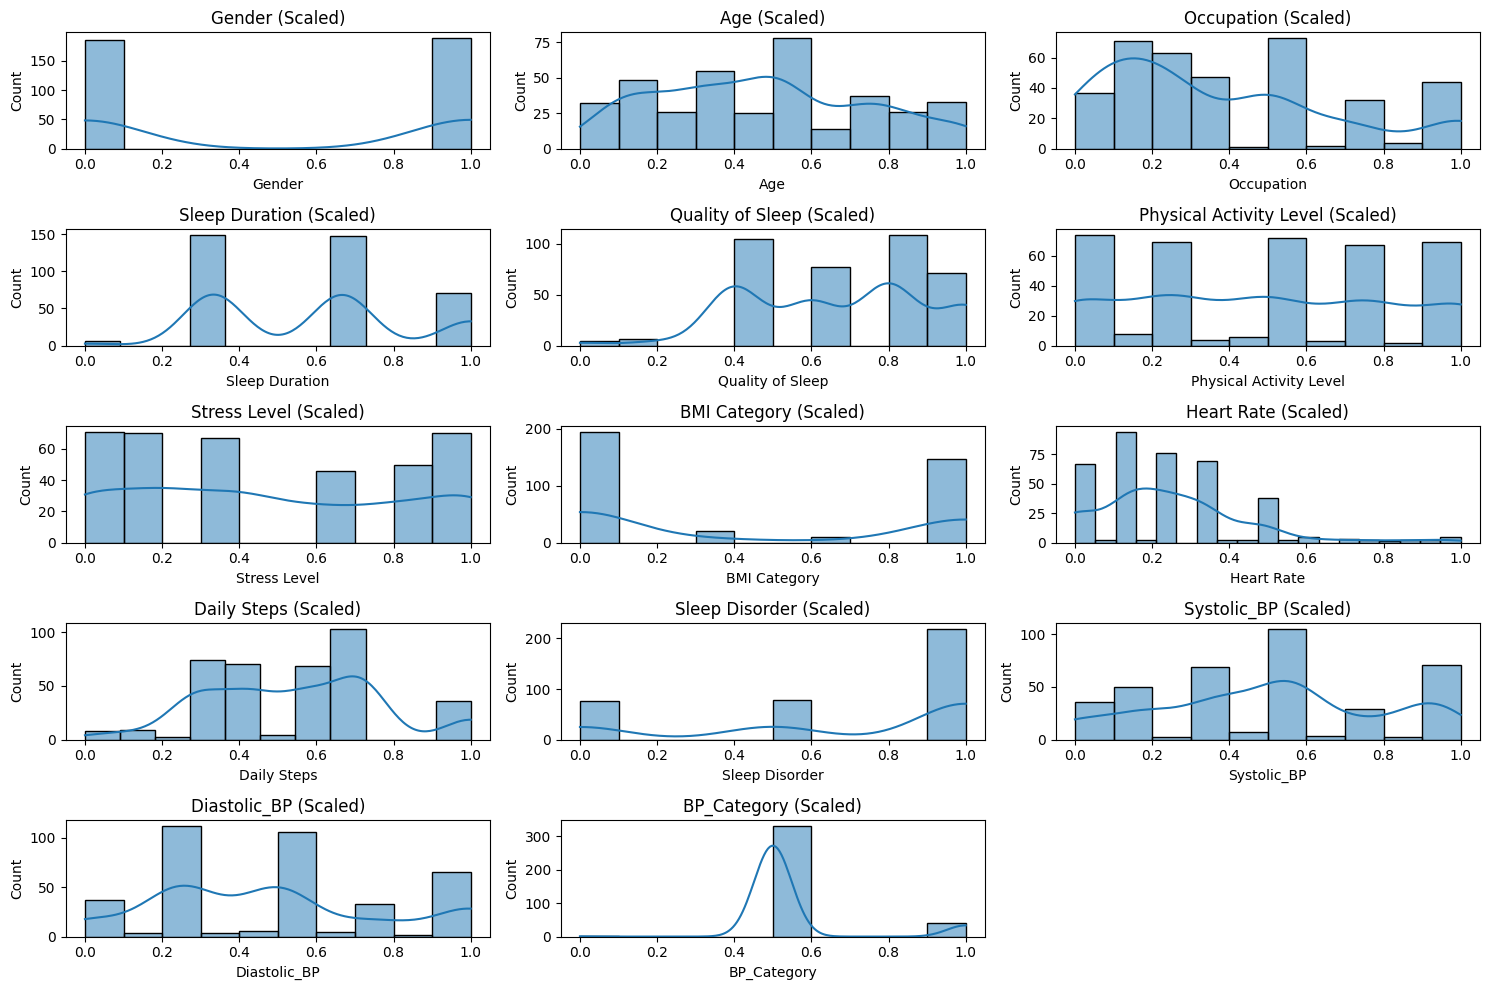

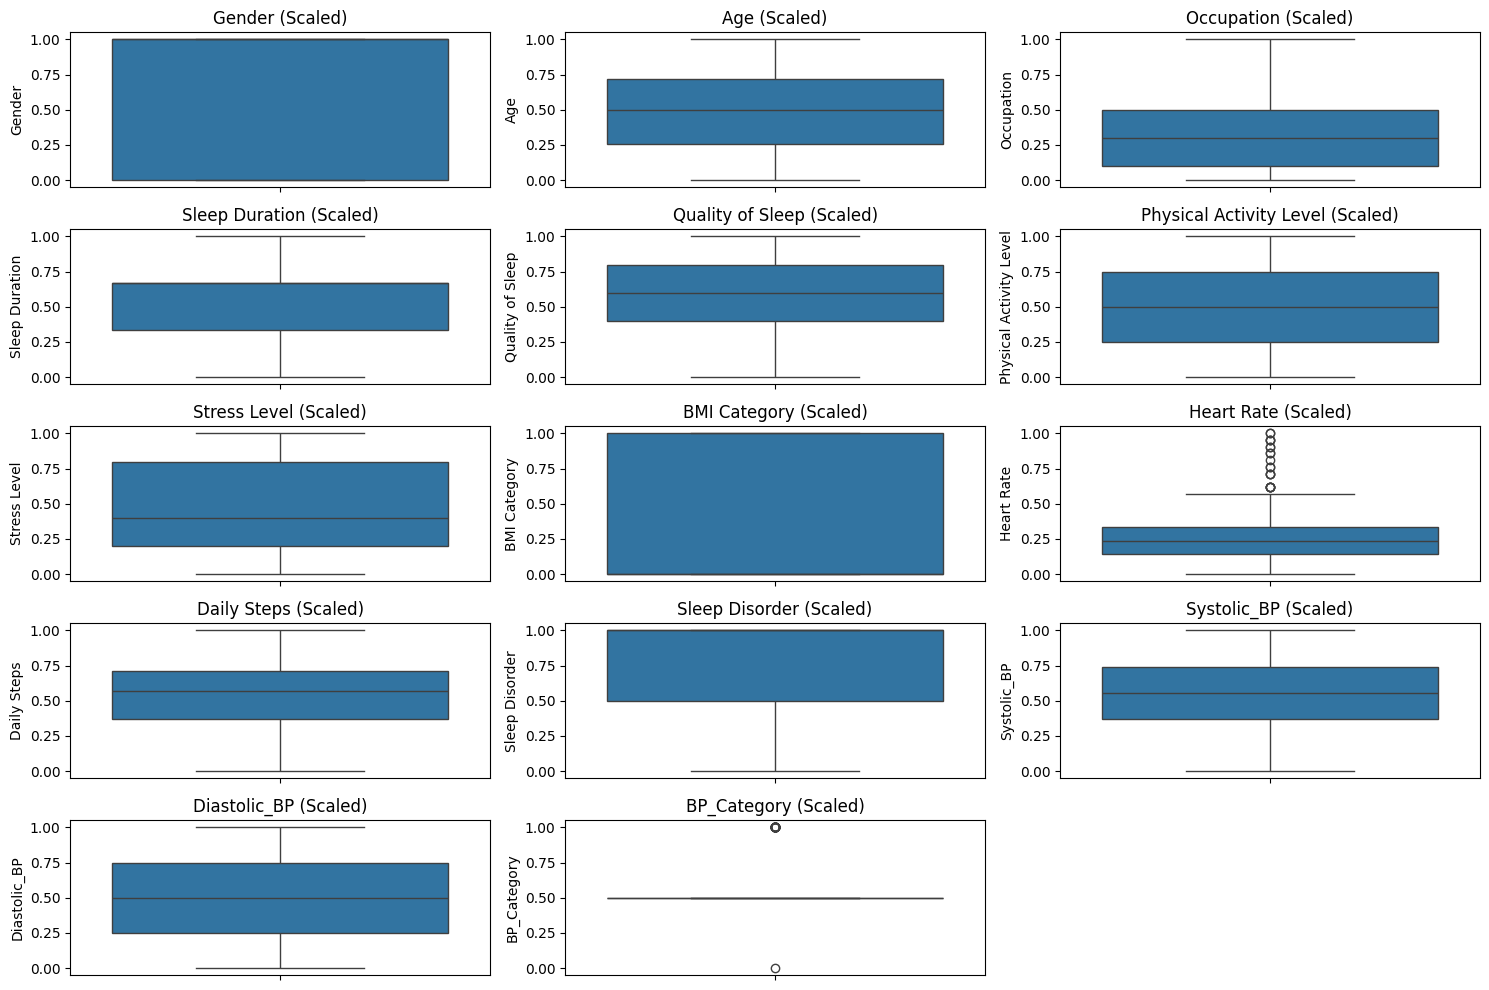

In [46]:
# Numerical features
numerical_cols = df.select_dtypes(include=np.number).columns

# Calculate the number of rows and columns for subplots
num_cols = len(numerical_cols)
num_rows = int(np.ceil(num_cols / 3))

# Plotting histograms for numerical features AFTER scaling
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col + " (Scaled)")
    plt.tight_layout()
plt.show()


# Plotting box plots for numerical features to check for outliers AFTER scaling
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col + " (Scaled)")
    plt.tight_layout()
plt.show()

In [47]:
print("\nUnique mappings for 'Occupation' before scaling:")
print(unique_mappings['Occupation'])

occupation_column = df['Occupation'].unique()

print("\n'Occupation' values after scaling:")
occupation_column


Unique mappings for 'Occupation' before scaling:
                Original  Encoded
0             Accountant        0
1                 Doctor        1
2               Engineer        2
3                 Lawyer        3
4                Manager        4
5                  Nurse        5
6   Sales Representative        6
7            Salesperson        7
8              Scientist        8
9      Software Engineer        9
10               Teacher       10

'Occupation' values after scaling:


array([0.9, 0.1, 0.6, 1. , 0.5, 0.2, 0. , 0.8, 0.3, 0.7, 0.4])

Correlation Analysis

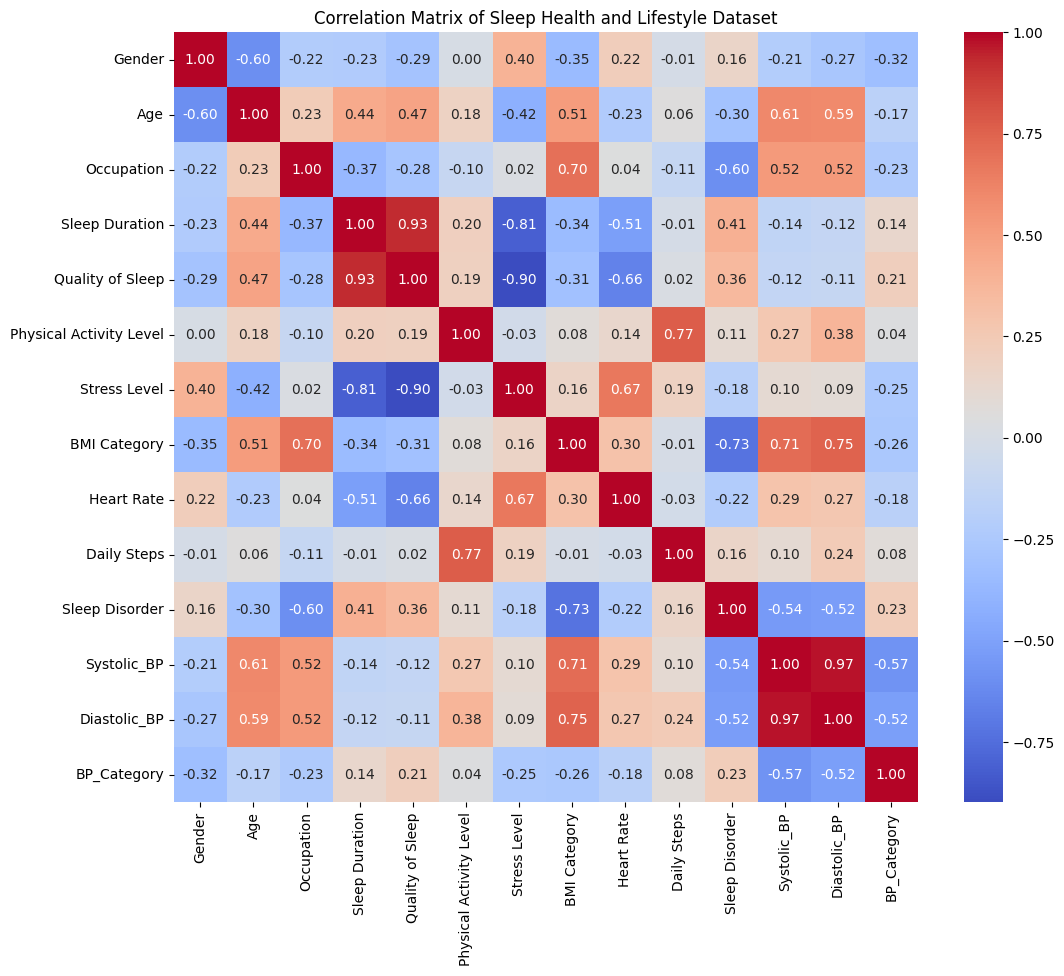


Correlation with 'Sleep Disorder':


,Sleep Disorder
Sleep Disorder,1.000000
Sleep Duration,0.410213
Quality of Sleep,0.357477
BP_Category,0.228260
Daily Steps,0.161275
Gender,0.161131
Physical Activity Level,0.109225
Stress Level,-0.181296
Heart Rate,-0.220913
Age,-0.303962


In [48]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sleep Health and Lifestyle Dataset')
plt.show()

correlation_with_sleep_disorder = correlation_matrix['Sleep Disorder'].sort_values(ascending=False)
print("\nCorrelation with 'Sleep Disorder':")
correlation_with_sleep_disorder

Distributions

In [49]:
print(df.dtypes)

Gender                     float64
Age                        float64
Occupation                 float64
Sleep Duration             float64
Quality of Sleep           float64
Physical Activity Level    float64
Stress Level               float64
BMI Category               float64
Heart Rate                 float64
Daily Steps                float64
Sleep Disorder             float64
Systolic_BP                float64
Diastolic_BP               float64
BP_Category                float64
dtype: object


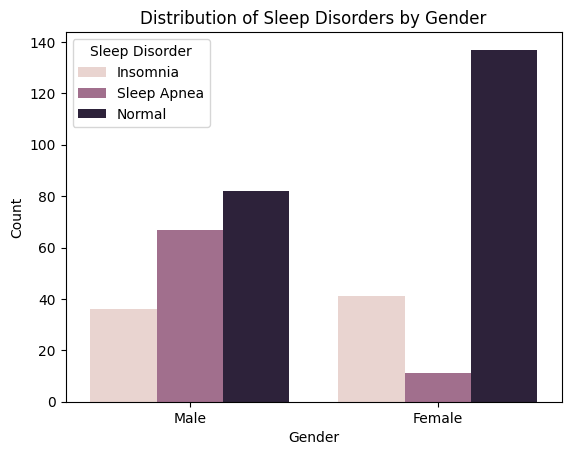

In [50]:
sns.countplot(x='Gender', hue='Sleep Disorder', data=df)
plt.title("Distribution of Sleep Disorders by Gender")
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.xlabel("Gender")
plt.ylabel("Count")

plt.legend(
    title="Sleep Disorder",
    labels=['Insomnia', 'Sleep Apnea', 'Normal'],
    loc='upper left',
    fontsize=10
)

plt.show()

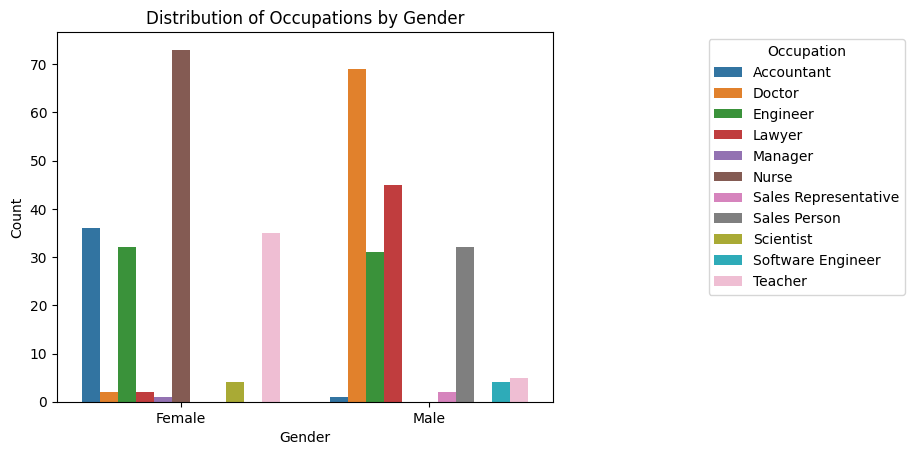

In [51]:
gender_order = [1,0]
occupation_order = ['Accountant', 'Doctor', 'Engineer', 'Lawyer', 'Manager', 'Nurse', 'Sales Representative', 'Sales Person', 'Scientist', 'Software Engineer', 'Teacher']
custom_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#f7b6d2'
]

sns.countplot(
    x='Gender',
    hue='Occupation',
    data=df,
    palette=custom_palette
)

plt.title("Distribution of Occupations by Gender")
plt.xticks(ticks=[1,0], labels=['Male', 'Female'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(
    title="Occupation",
    labels=occupation_order,
    bbox_to_anchor=(1.3, 1),
    loc='upper left',
    fontsize=10
)
plt.show()

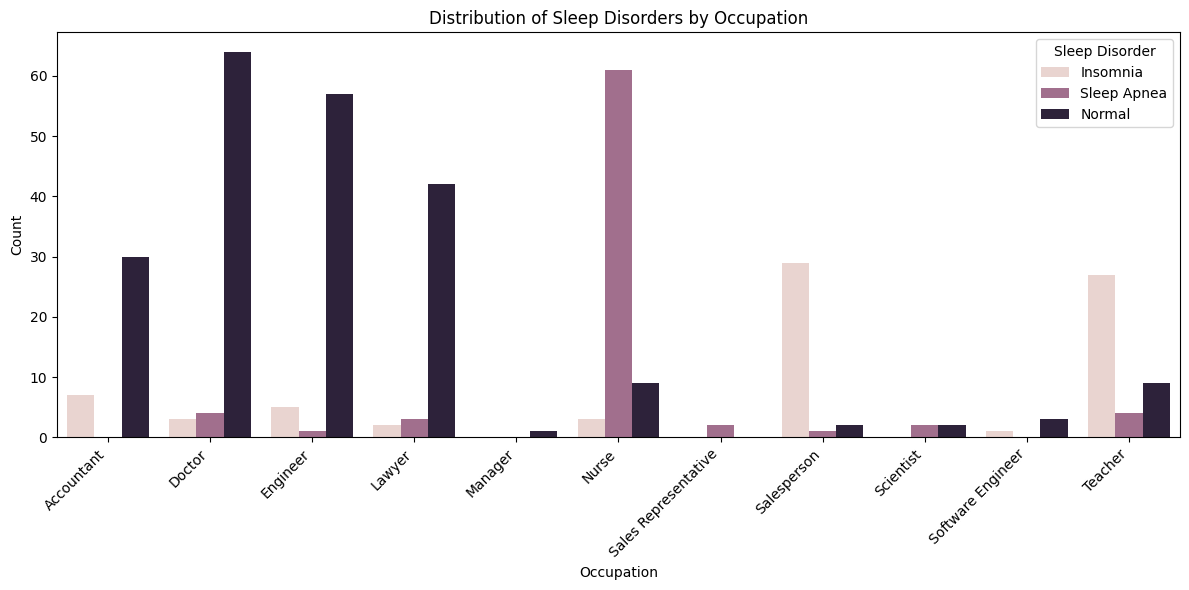

In [52]:
# Create the countplot
plt.figure(figsize=(12, 6))
sns.countplot(x='Occupation', hue='Sleep Disorder', data=df)
plt.title('Distribution of Sleep Disorders by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Replace numerical occupation labels with original names
occupation_mapping = unique_mappings['Occupation']
plt.xticks(ticks=range(len(occupation_mapping['Encoded'])), labels=occupation_mapping['Original'])
plt.legend(title='Sleep Disorder', labels=['Insomnia', 'Sleep Apnea', 'Normal'])
plt.tight_layout()
plt.show()

In [53]:
# Reverse scaling to match original integer values
max_original = 10
min_original = 0

# Perform reverse scaling on the 'Occupation' column without adding it to df
occupation_original = (df['Occupation'] * (max_original - min_original) + min_original).round().astype(int)

# Map back to the provided categories
provided_mapping = {
    0: 'Accountant', 1: 'Doctor', 2: 'Engineer', 3: 'Lawyer', 4: 'Manager',
    5: 'Nurse', 6: 'Sales Representative', 7: 'Salesperson',
    8: 'Scientist', 9: 'Software Engineer', 10: 'Teacher'
}

# Map the scaled values back to original categories
occupation_mapped = occupation_original.map(provided_mapping)

# Check for mismatched values
mismatched = occupation_mapped[occupation_mapped.isnull()]

if not mismatched.empty:
    print("Mismatched values found:")
    print(mismatched)
else:
    print("All values match the provided mapping.")


All values match the provided mapping.


In [54]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic_BP,Diastolic_BP,BP_Category
0,1.0,0.00000,0.9,0.333333,0.4,0.2,0.6,1.000000,0.571429,0.171429,1.0,0.407407,0.40,0.5
1,1.0,0.03125,0.1,0.333333,0.4,0.5,1.0,0.000000,0.476190,1.000000,1.0,0.370370,0.25,0.5
2,1.0,0.03125,0.1,0.333333,0.4,0.5,1.0,0.000000,0.476190,1.000000,1.0,0.370370,0.25,0.5
3,1.0,0.03125,0.6,0.000000,0.0,0.0,1.0,0.666667,0.952381,0.000000,0.5,0.925926,0.75,0.5
4,1.0,0.03125,0.6,0.000000,0.0,0.0,1.0,0.666667,0.952381,0.000000,0.5,0.925926,0.75,0.5


In [55]:
df_version2 = df.copy()

# Training Model

In [56]:
df['Occupation'].unique()

array([0.9, 0.1, 0.6, 1. , 0.5, 0.2, 0. , 0.8, 0.3, 0.7, 0.4])

Version 1: Only Features Chosen: 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'BMI Category', 'Stress Level'


Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

    Insomnia       0.91      0.98      0.94        43
        None       0.81      0.81      0.81        16
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.86      0.83      0.84        75
weighted avg       0.88      0.88      0.88        75



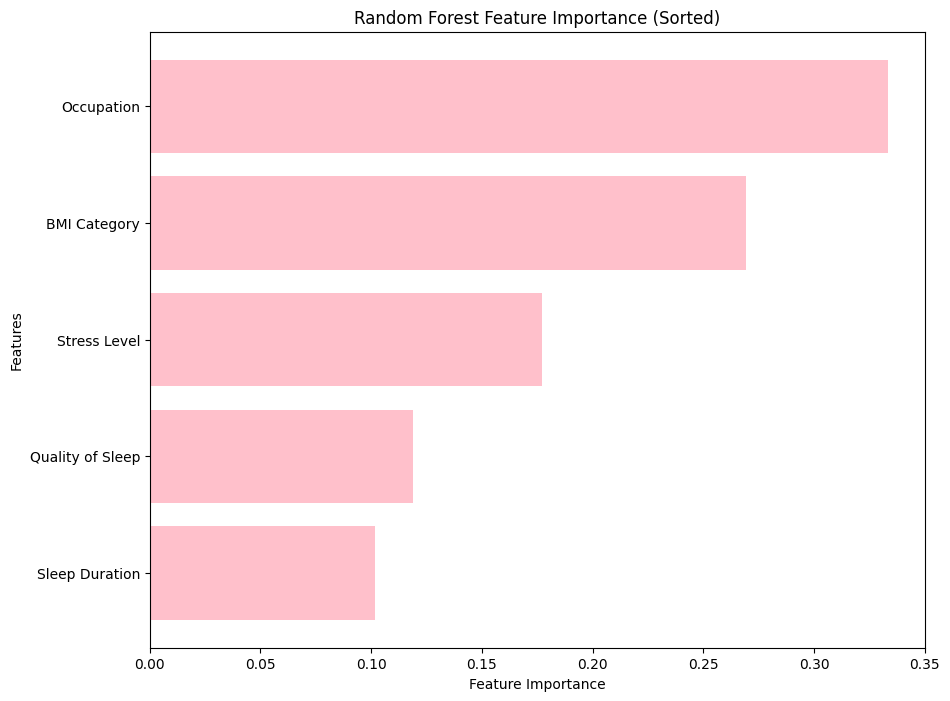

In [57]:
features = ['Occupation', 'Sleep Duration', 'Quality of Sleep', 'BMI Category', 'Stress Level']
target = 'Sleep Disorder'

X = df[features]
y = df[target]

# Map the target variable to numeric classes
class_mapping = {0: "None", 0.5: "Sleep Apnea", 1: "Insomnia"}
y_encoded = y.map(class_mapping)

X_train, X_test, y_train, y_test_v1 = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model_v1 = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model_v1.fit(X_train, y_train)

y_pred_v1 = rf_model_v1.predict(X_test)

print("Accuracy:", accuracy_score(y_test_v1, y_pred_v1))
print("Classification Report:\n", classification_report(y_test_v1, y_pred_v1))

# Get the feature importances from the trained random forest model
importances = rf_model_v1.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='pink')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance (Sorted)')
plt.show()

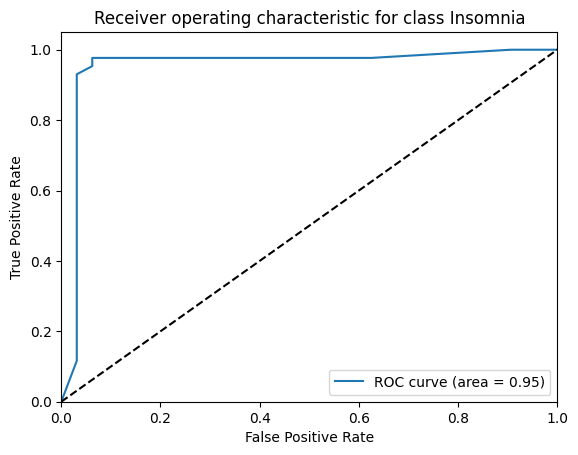

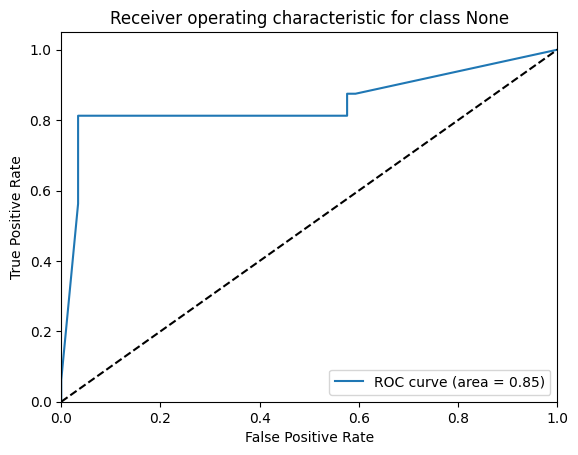

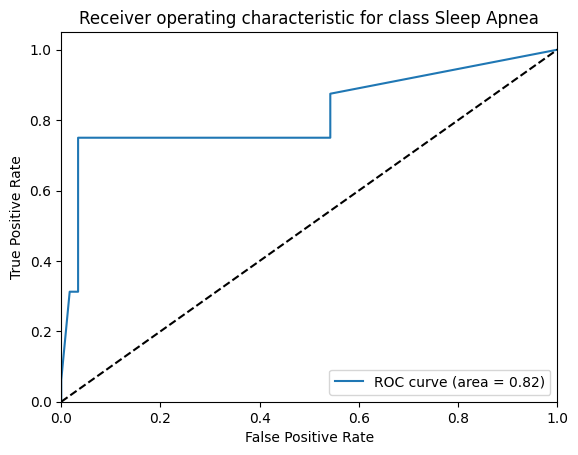

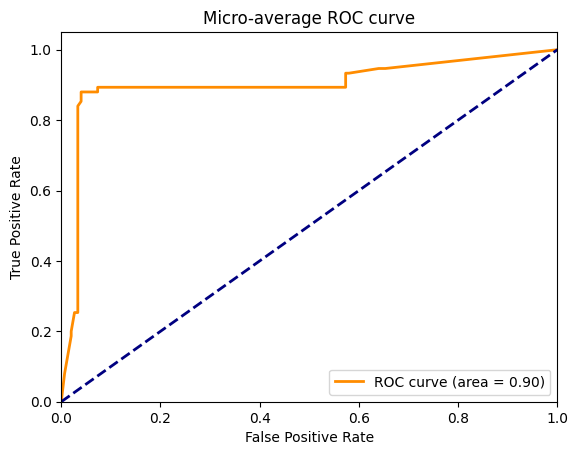

In [58]:
# Binarize the output
y_test_bin = label_binarize(y_test_v1, classes=rf_model_v1.classes_)
y_score = rf_model_v1.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(rf_model_v1.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(rf_model_v1.classes_[i]))
    plt.legend(loc="lower right")
    plt.show()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC curve')
plt.legend(loc="lower right")
plt.show()

In [59]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic_BP,Diastolic_BP,BP_Category
0,1.0,0.00000,0.9,0.333333,0.4,0.2,0.6,1.000000,0.571429,0.171429,1.0,0.407407,0.40,0.5
1,1.0,0.03125,0.1,0.333333,0.4,0.5,1.0,0.000000,0.476190,1.000000,1.0,0.370370,0.25,0.5
2,1.0,0.03125,0.1,0.333333,0.4,0.5,1.0,0.000000,0.476190,1.000000,1.0,0.370370,0.25,0.5
3,1.0,0.03125,0.6,0.000000,0.0,0.0,1.0,0.666667,0.952381,0.000000,0.5,0.925926,0.75,0.5
4,1.0,0.03125,0.6,0.000000,0.0,0.0,1.0,0.666667,0.952381,0.000000,0.5,0.925926,0.75,0.5


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_test = y_test_v1  # Actual labels
y_pred = y_pred_v1 # Predicted labels

precision = precision_score(y_test_v1, y_pred_v1, average='weighted')
recall = recall_score(y_test_v1, y_pred_v1, average='weighted')
f1 = f1_score(y_test_v1, y_pred_v1, average='weighted')
accuracy = accuracy_score(y_test_v1, y_pred_v1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


Precision: 0.877324414715719
Recall: 0.88
F1 Score: 0.8762960092987214
Accuracy: 0.88


Version 2:

In [61]:
df_version2 = pd.get_dummies(df_version2, columns=['Occupation', 'BMI Category'], drop_first=True)


In [62]:
#mapping and cleaning the occupation column
occupation_mapping = {
    0.0: 'Accountant',
    0.1: 'Doctor',
    0.2: 'Engineer',
    0.3: 'Lawyer',
    0.4: 'Manager',
    0.5: 'Nurse',
    0.6: 'Sales Representative',
    0.7: 'Salesperson',
    0.8: 'Scientist',
    0.9: 'Software Engineer',
    1.0: 'Teacher'
}
#mapping and cleaning the BMI column
bmi_mapping = {
    0: 'Normal',
    0.33333333: 'Normal Weight',
    0.66666667: 'Obese',
    1.0: 'Overweight'
}

In [63]:
X = df_version2.drop(columns=['Person ID', 'Gender', 'Age', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder'], errors='ignore')
y = df_version2['Sleep Disorder']

y_encoded = y.map(class_mapping)

#splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#training the random forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

Unmapped features after mapping: []


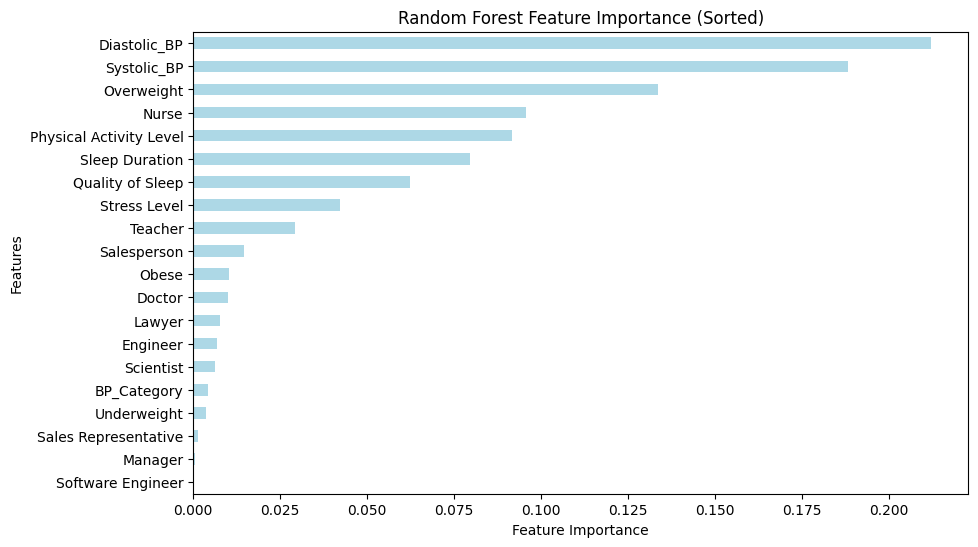

In [64]:
# Create reverse mappings
occupation_reverse_mapping = {f'Occupation_{key}': value for key, value in occupation_mapping.items()}
bmi_reverse_mapping = {f'BMI Category_{key}': value for key, value in bmi_mapping.items()}

# Additional BMI category to human-readable mapping
bmi_category_mapping = {
    'BMI Category_0.7': 'Obese',
    'BMI Category_0.3': 'Underweight',
}

# Define function to handle rounding and mapping, including custom category labels
def round_and_map_feature(feature, mapping, prefix, category_mapping=None, decimals=1):
    if feature.startswith(prefix):
        try:
            # Extract the numeric part, round it, and reconstruct the key
            numeric_part = float(feature.split('_')[1])
            rounded_key = f"{prefix}_{round(numeric_part, decimals)}"

            # First check if it has a custom mapping in the category_mapping
            if category_mapping and rounded_key in category_mapping:
                return category_mapping[rounded_key]

            # Otherwise fall back to the regular mapping
            return mapping.get(rounded_key, feature)
        except ValueError:
            return feature
    return feature

feature_importances = rf_model.feature_importances_
sorted_feature_importances = pd.Series(feature_importances, index=X.columns).sort_values(ascending=True)

# Replace feature names using the round_and_map_feature function
sorted_feature_importances.index = sorted_feature_importances.index.map(
    lambda x: round_and_map_feature(x, occupation_reverse_mapping, "Occupation")
)
sorted_feature_importances.index = sorted_feature_importances.index.map(
    lambda x: round_and_map_feature(x, bmi_reverse_mapping, "BMI Category", bmi_category_mapping, decimals=1)
)

# Check unmapped features after mapping
unmapped_features = [
    feature for feature in sorted_feature_importances.index
    if "Occupation_" in feature or "BMI Category_" in feature
]
print("Unmapped features after mapping:", unmapped_features)

plt.figure(figsize=(10, 6))
sorted_feature_importances.plot(kind='barh', color='lightblue')
plt.title('Random Forest Feature Importance (Sorted)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [65]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

    Insomnia       0.95      0.98      0.97        43
        None       0.72      0.81      0.76        16
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



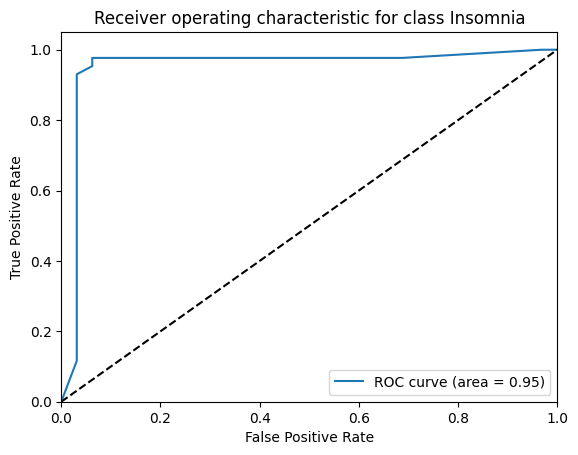

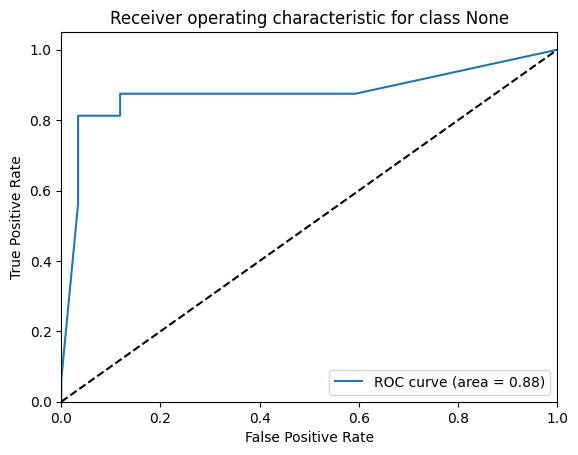

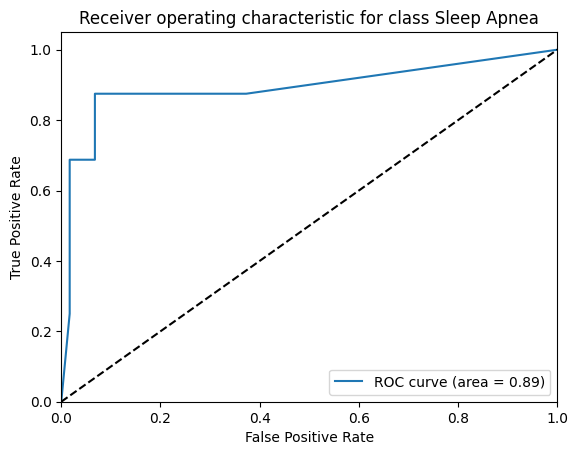

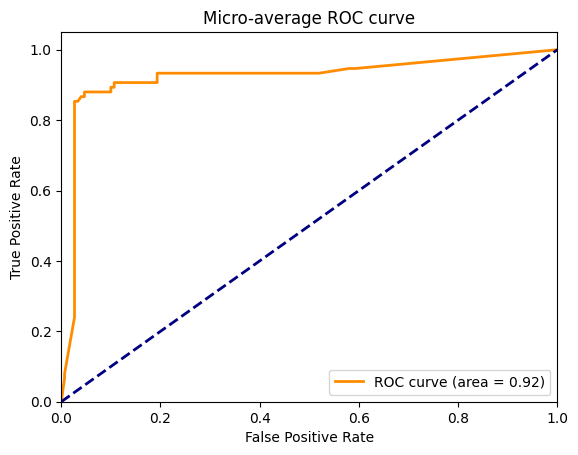

In [66]:
# Binarize the output
y_test_bin = label_binarize(y_test, classes=rf_model.classes_)
y_score = rf_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(rf_model.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(rf_model.classes_[i]))
    plt.legend(loc="lower right")
    plt.show()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC curve')
plt.legend(loc="lower right")
plt.show()

In [67]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.8818596218596219
Recall: 0.88
F1 Score: 0.8785395537525356
Accuracy: 0.88


In [68]:
print("Feature importance index before mapping:", sorted_feature_importances.index.tolist())
print("Occupation mapping keys:", list(occupation_reverse_mapping.keys()))
print("BMI mapping keys:", list(bmi_reverse_mapping.keys()))

Feature importance index before mapping: ['Software Engineer', 'Manager', 'Sales Representative', 'Underweight', 'BP_Category', 'Scientist', 'Engineer', 'Lawyer', 'Doctor', 'Obese', 'Salesperson', 'Teacher', 'Stress Level', 'Quality of Sleep', 'Sleep Duration', 'Physical Activity Level', 'Nurse', 'Overweight', 'Systolic_BP', 'Diastolic_BP']
Occupation mapping keys: ['Occupation_0.0', 'Occupation_0.1', 'Occupation_0.2', 'Occupation_0.3', 'Occupation_0.4', 'Occupation_0.5', 'Occupation_0.6', 'Occupation_0.7', 'Occupation_0.8', 'Occupation_0.9', 'Occupation_1.0']
BMI mapping keys: ['BMI Category_0', 'BMI Category_0.33333333', 'BMI Category_0.66666667', 'BMI Category_1.0']


# Optimization

In [69]:
df_version3 = pd.read_csv(file_path)
df_version3.drop(columns=['Person ID'], inplace=True)

df_version3[['Systolic_BP', 'Diastolic_BP']] = df_version3['Blood Pressure'].str.split('/', expand=True).astype(int)

def categorize_bp(row):
    systolic = row['Systolic_BP']
    diastolic = row['Diastolic_BP']
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif systolic >= 130 or diastolic >= 80:
        return 'Hypertension'
    return 'Unknown'

df_version3['BP_Category'] = df_version3.apply(categorize_bp, axis=1)

df_version3.drop(columns=['Blood Pressure'], inplace=True)

print("Unique values in 'Sleep Disorder' before mapping:")
print(df_version3['Sleep Disorder'].unique())

Unique values in 'Sleep Disorder' before mapping:
[nan 'Sleep Apnea' 'Insomnia']


In [70]:
df_version3['Sleep Disorder'] = df_version3['Sleep Disorder'].fillna('None')

# Update the mapping based on the unique values
sleep_disorder_mapping = {'None': 0, 'Sleep Apnea': 1, 'Insomnia': 2}
df_version3['Sleep Disorder'] = df_version3['Sleep Disorder'].map(sleep_disorder_mapping)

num_nans = df_version3['Sleep Disorder'].isnull().sum()
print(f"Number of NaNs in 'Sleep Disorder' after mapping: {num_nans}")
y = df_version3['Sleep Disorder']

df_version3['Gender'] = df_version3['Gender'].map({'Male': 0, 'Female': 1})

# One-hot encoding for 'Occupation', 'BMI Category', and 'BP_Category'
df_version3 = pd.get_dummies(df_version3, columns=['Occupation', 'BMI Category', 'BP_Category'], drop_first=True)


X = df_version3.drop(columns=['Sleep Disorder'], errors='ignore')

# Ensure no NaNs in features
print("Number of NaNs in X:", X.isnull().sum().sum())


Number of NaNs in 'Sleep Disorder' after mapping: 0
Number of NaNs in X: 0


In [71]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search.fit(X, y)
best_rf = grid_search.best_estimator_

# Evaluate the best model using cross-validation
cv_results = cross_val_score(best_rf, X, y, cv=cv, scoring='f1_weighted', n_jobs=-1)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(best_rf, X, y, cv=cv, n_jobs=-1)

accuracy = accuracy_score(y, y_pred_cv)
precision = precision_score(y, y_pred_cv, average='weighted')
recall = recall_score(y, y_pred_cv, average='weighted')
f1 = f1_score(y, y_pred_cv, average='weighted')

print("Accuracy: {:.2f}".format(accuracy))

report = classification_report(y, y_pred_cv, target_names=['None', 'Sleep Apnea', 'Insomnia'])
print("\nClassification Report:\n", report)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

        None       0.95      0.95      0.95       219
 Sleep Apnea       0.86      0.87      0.87        78
    Insomnia       0.85      0.83      0.84        77

    accuracy                           0.91       374
   macro avg       0.89      0.88      0.89       374
weighted avg       0.91      0.91      0.91       374



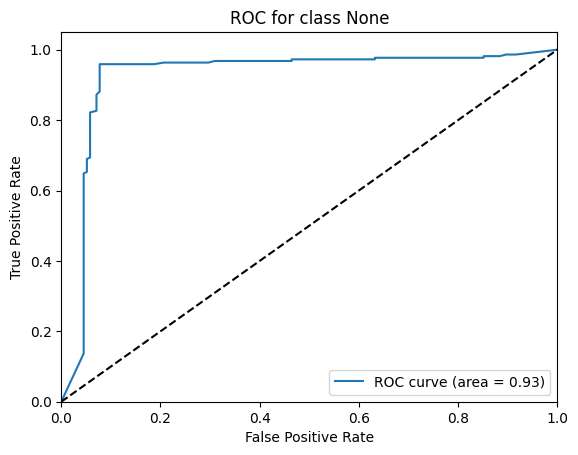

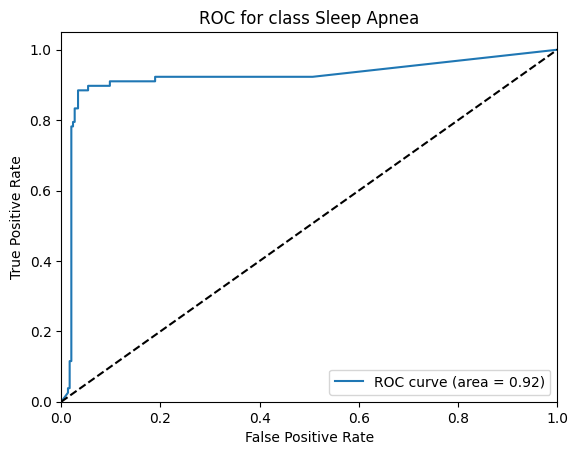

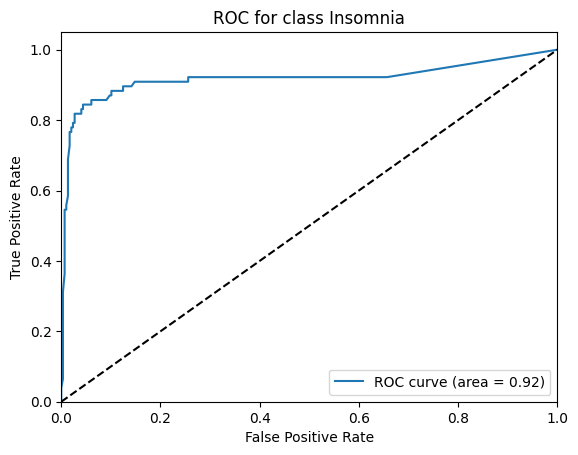

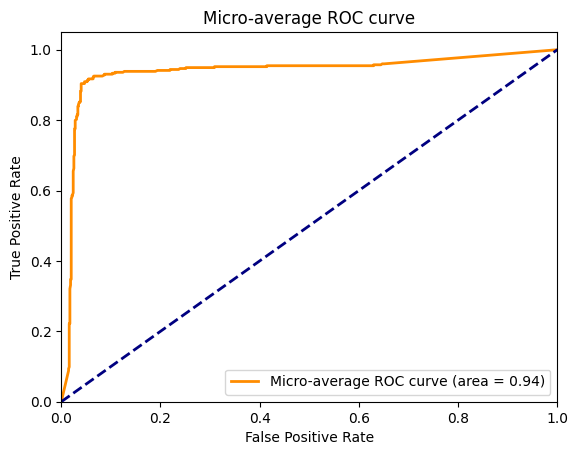

In [72]:
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Predict probabilities
y_score = cross_val_predict(best_rf, X, y, cv=cv, method='predict_proba', n_jobs=-1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for class {}'.format(['None', 'Sleep Apnea', 'Insomnia'][i]))
    plt.legend(loc="lower right")
    plt.show()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC curve')
plt.legend(loc="lower right")
plt.show()

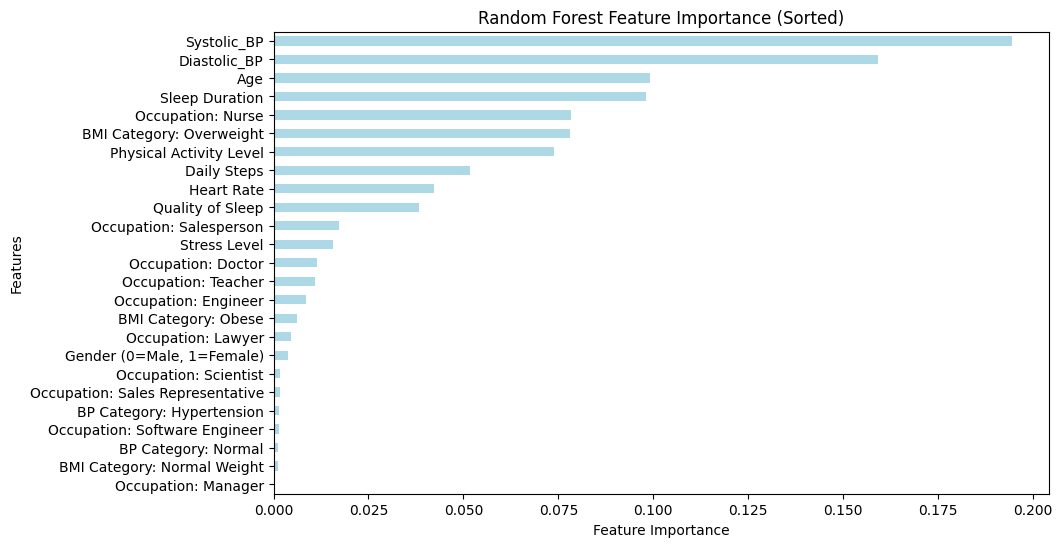

In [73]:
#  Feature importance
feature_importances = best_rf.feature_importances_
sorted_feature_importances = pd.Series(feature_importances, index=X.columns).sort_values(ascending=True)

# Replace feature names for better readability
def map_feature_names(feature):
    if 'Occupation_' in feature:
        return 'Occupation: ' + feature.replace('Occupation_', '')
    elif 'BMI Category_' in feature:
        return 'BMI Category: ' + feature.replace('BMI Category_', '')
    elif 'BP_Category_' in feature:
        return 'BP Category: ' + feature.replace('BP_Category_', '')
    elif feature == 'Gender':
        return 'Gender (0=Male, 1=Female)'
    else:
        return feature

sorted_feature_importances.index = sorted_feature_importances.index.map(map_feature_names)

plt.figure(figsize=(10, 6))
sorted_feature_importances.plot(kind='barh', color='lightblue')
plt.title('Random Forest Feature Importance (Sorted)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [74]:
# Recommendations dictionary for lifestyle changes
lifestyle_recommendations = {
    # BMI Category
    'BMI Category_1.0_True': 'Consider consulting a dietitian and incorporating regular physical activity to maintain a healthy weight.',
    'BMI Category_0.3333333333333333_True': 'Focus on a balanced diet with sufficient calorie intake to reach a healthy weight.',
    'BMI Category_0.6666666666666666_True': 'Focus on a balanced diet with sufficient calorie intake to reach a healthy weight',
    'BMI Category_0.0_True': 'Maintain a healthy weight through balanced eating and physical activity.',

    # Sleep Duration
    'Sleep Duration_0.0': 'Very low sleep duration detected. Try to establish a consistent bedtime routine and aim for at least 7 hours of sleep.',
    'Sleep Duration_0.25': 'Sleep duration is below recommended. Adjust your daily schedule to prioritize more sleep.',
    'Sleep Duration_0.5': 'Your sleep duration is moderate, but aim to increase it to 7-9 hours for optimal health.',
    'Sleep Duration_0.75': 'Your sleep duration is near the recommended range. Consistency can further improve your sleep quality.',
    'Sleep Duration_1.0': 'You have healthy sleep duration. Keep maintaining this schedule.',

    # Quality of Sleep
    'Quality of Sleep_0.0': 'Poor sleep quality detected. Avoid screens before bed and consider relaxation techniques.',
    'Quality of Sleep_0.25': 'Your sleep quality is below average. Create a calming bedtime routine to improve it.',
    'Quality of Sleep_0.5': 'Moderate sleep quality. Small adjustments to your environment can improve restfulness.',
    'Quality of Sleep_0.75': 'Good sleep quality. Continue maintaining these habits for restful sleep.',
    'Quality of Sleep_1.0': 'Excellent sleep quality. Keep up the great work!',

    # Physical Activity Level
    'Physical Activity Level_0.0': 'Consider starting with light activities like walking to improve physical health.',
    'Physical Activity Level_0.25': 'Increase your activity level gradually to meet the recommended 30 minutes of daily exercise.',
    'Physical Activity Level_0.5': 'Moderate activity level. Incorporating more consistent exercise can enhance health.',
    'Physical Activity Level_0.75': 'Good activity level. Try to maintain or slightly increase consistency.',
    'Physical Activity Level_1.0': 'Excellent activity level! Keep up your regular exercise routine.',

    # Stress Level
    'Stress Level_0.19999999999999996': 'Mild stress detected. Consider relaxation techniques like meditation or yoga.',
    'Stress Level_0.3999999999999999': 'Moderate stress level. Balance work and rest, and engage in stress-relieving activities.',
    'Stress Level_0.8': 'High stress level detected. Prioritize self-care and consider seeking support or counseling.',
    'Stress Level_1.0': 'Very high stress level detected. Immediate action such as speaking to a professional may be necessary.',

    # BP Category
    'BP_Category_0.0': 'Normal blood pressure. Maintain a healthy diet and regular physical activity to keep it that way.',
    'BP_Category_0.5': 'Moderate blood pressure. Consider reducing salt intake and incorporating regular exercise.',
    'BP_Category_1.0': 'High blood pressure. Consult a healthcare professional and adopt a heart-healthy diet.',
}

# Function to provide recommendations for each individual
def generate_recommendations(X, y_pred, recommendations):
    """
    Generate lifestyle recommendations based on individual features and predictions.

    Parameters:
    - X (DataFrame): Input features for each individual.
    - y_pred (array-like): Predicted classifications for each individual.
    - recommendations (dict): Dictionary mapping feature names or values to recommendations.

    Returns:
    - dict: Recommendations for each individual.
    """
    individual_recommendations = {}

    # Ensure that X and y_pred are aligned
    for index, (row, pred) in enumerate(zip(X.iterrows(), y_pred)):
        sample_recommendations = []
        # Predicted classification for the individual
        if pred == 'None':
            sample_recommendations.append('Healthy. Keep up your current habits.')
        else:
            # Check feature values and match with recommendations
            for feature in row[1].index:
                feature_value = f"{feature}_{row[1][feature]}"
                if feature_value in recommendations:
                    sample_recommendations.append(recommendations[feature_value])

        individual_recommendations[f"Sample {index}"] = sample_recommendations

    return individual_recommendations

# Apply the recommendations on the training data
recommendations_train = generate_recommendations(X_train, y_pred, lifestyle_recommendations)

# Display recommendations for each individual
for sample, recs in recommendations_train.items():
    print(f"\n{sample} Recommendations:")
    if recs:
        for rec in recs:
            print(f"- {rec}")
    else:
        print("- No specific recommendations.")



Sample 0 Recommendations:
- Increase your activity level gradually to meet the recommended 30 minutes of daily exercise.
- High stress level detected. Prioritize self-care and consider seeking support or counseling.
- Moderate blood pressure. Consider reducing salt intake and incorporating regular exercise.
- Consider consulting a dietitian and incorporating regular physical activity to maintain a healthy weight.

Sample 1 Recommendations:
- Consider starting with light activities like walking to improve physical health.
- Very high stress level detected. Immediate action such as speaking to a professional may be necessary.
- Moderate blood pressure. Consider reducing salt intake and incorporating regular exercise.

Sample 2 Recommendations:
- Moderate activity level. Incorporating more consistent exercise can enhance health.
- Moderate stress level. Balance work and rest, and engage in stress-relieving activities.
- Moderate blood pressure. Consider reducing salt intake and incorpora